<a href="https://colab.research.google.com/github/RaphaelUCL/all/blob/main/implied_vol_surface_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implied Volatility Surface Construction

In this notebook, we build an **implied volatility (IV) surface**, a key tool in quantitative finance and option pricing.

The IV surface represents how implied volatility varies with **strike price** and **time to maturity**, helping traders and quants to:
- Visualize market expectations of future volatility
- Detect pricing anomalies or arbitrage opportunities
- Calibrate option pricing models (e.g. Black-Scholes, SABR)

Since real option market data can be noisy or difficult to obtain, we start by generating **mock data** that mimics realistic market behavior (volatility smile and skew).

We will then:
1. Interpolate the data across strikes and maturities
2. Reconstruct a smooth surface
3. Visualize it in 3D using Plotly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, Rbf
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

### Part 1: Generating Mock Option Data

We begin by creating a **mock dataset** of option quotes with implied volatilities across different strikes and maturities.

This function simulates a typical market behavior where:
- **At-the-money (ATM)** options have the lowest implied volatility
- **Deep in/out-of-the-money** options show higher volatility due to the **volatility smile**
- There's also a slight **skew** that depends on moneyness (ratio strike / spot)

The generated data includes:
- A range of strikes around a spot price (e.g., 4000)
- Maturities from 30 to 730 days (converted to years)
- Implied volatilities that vary with both strike and time to maturity

We'll use this data to construct and visualize a smooth volatility surface in later steps.


In [2]:
def generate_mock_options_data(num_strikes=15, num_maturities=8):
    spot_price = 4000
    moneyness = np.linspace(0.8, 1.2, num_strikes)
    strikes = [spot_price * m for m in moneyness]
    maturities_days = [30, 60, 90, 180, 270, 365, 545, 730]
    maturities_years = [d/365 for d in maturities_days[:num_maturities]]
    data = []
    for maturity in maturities_years:
        smile_intensity = np.exp(-2 * maturity) * 0.5 + 0.1
        base_vol = 0.15 + 0.05 * np.sqrt(maturity)
        for strike in strikes:
            k_norm = strike / spot_price
            skew = -0.1 * (k_norm - 1)
            smile = smile_intensity * (k_norm - 1)**2
            iv = base_vol + skew + smile
            iv = max(0.05, iv + np.random.normal(0, 0.01))
            data.append({'strike': strike, 'maturity': maturity, 'implied_volatility': iv})
    return pd.DataFrame(data)


### Part 2: Volatility Surface Interpolation

Once we have the implied volatility data, the next step is to **interpolate it** over a continuous grid of strikes and maturities.

We provide two interpolation methods:

- **Griddata Interpolation** (`interpolate_vol_surface`)  
  Uses `scipy.interpolate.griddata` to interpolate on a uniform meshgrid, supporting methods like `'linear'`, `'cubic'`, or `'nearest'`. This is useful for smooth surface reconstruction.

- **Radial Basis Function (RBF) Interpolation** (`interpolate_vol_surface_rbf`)  
  Uses `scipy.interpolate.Rbf` for flexible and continuous interpolation. The `'thin_plate'` kernel is a good default, but others like `'multiquadric'` or `'gaussian'` can also be tested.

These interpolated surfaces will allow us to visualize the implied volatility landscape across all strike/maturity combinations — even between observed data points.


In [3]:
def interpolate_vol_surface(df, method='cubic', num_points=50):
    strikes = df['strike'].values
    maturities = df['maturity'].values
    ivs = df['implied_volatility'].values
    strike_range = np.linspace(strikes.min(), strikes.max(), num_points)
    maturity_range = np.linspace(maturities.min(), maturities.max(), num_points)
    X, Y = np.meshgrid(strike_range, maturity_range)
    points = np.column_stack([strikes, maturities])
    Z = griddata(points, ivs, (X, Y), method=method)
    return X, Y, Z

def interpolate_vol_surface_rbf(df, function='thin_plate'):
    strikes = df['strike'].values
    maturities = df['maturity'].values
    ivs = df['implied_volatility'].values
    rbf = Rbf(strikes, maturities, ivs, function=function)
    return rbf


### Part 3: Visualization of the Volatility Smile and Surface

Now that we have interpolated the implied volatility data, we can visualize it in both 2D and 3D.

We provide three plotting functions:

- **`plot_volatility_smile()`**  
  Plots the implied volatility curve (smile) for selected maturities.  
  This lets us observe how the IV curve shifts and bends depending on time to maturity.

- **`plot_3d_vol_surface()`**  
  Generates a 3D matplotlib plot of the interpolated volatility surface over strike and maturity.  
  Useful for static, publication-style visualization.

- **`plot_plotly_vol_surface()`**  
  Uses Plotly to create an interactive 3D surface, which allows zooming, rotating, and tooltip display.  
  Ideal for exploratory analysis or web presentation.

These visual tools help us better understand how volatility varies across the option chain and how it evolves with maturity.


In [4]:
def plot_volatility_smile(df, maturities_to_plot=None):
    if maturities_to_plot is None:
        all_maturities = sorted(df['maturity'].unique())
        maturities_to_plot = [all_maturities[0], all_maturities[len(all_maturities)//2], all_maturities[-1]]
    plt.figure(figsize=(12, 6))
    for maturity in maturities_to_plot:
        maturity_data = df[np.isclose(df['maturity'], maturity)].sort_values('strike')
        plt.plot(maturity_data['strike'], maturity_data['implied_volatility'], 'o-', label=f'T = {maturity:.2f} years')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title('Volatility Smile for Different Maturities')
    plt.legend()
    plt.show()

def plot_3d_vol_surface(X, Y, Z):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Implied Volatility')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity (years)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Implied Volatility Surface')
    plt.tight_layout()
    plt.show()

def plot_plotly_vol_surface(X, Y, Z):
    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', colorbar=dict(title='IV'))])
    fig.update_layout(title='Implied Volatility Surface',
                      scene=dict(xaxis_title='Strike', yaxis_title='Maturity (years)', zaxis_title='Implied Volatility'),
                      width=900, height=700, margin=dict(l=65, r=50, b=65, t=90))
    fig.show()


### Part 4: Main Analysis

This function runs the full workflow:

- Generates mock option data  
- Plots volatility smiles  
- Interpolates the IV surface
- Displays both static and interactive 3D visualizations

Below, we run the analysis using **cubic interpolation**.

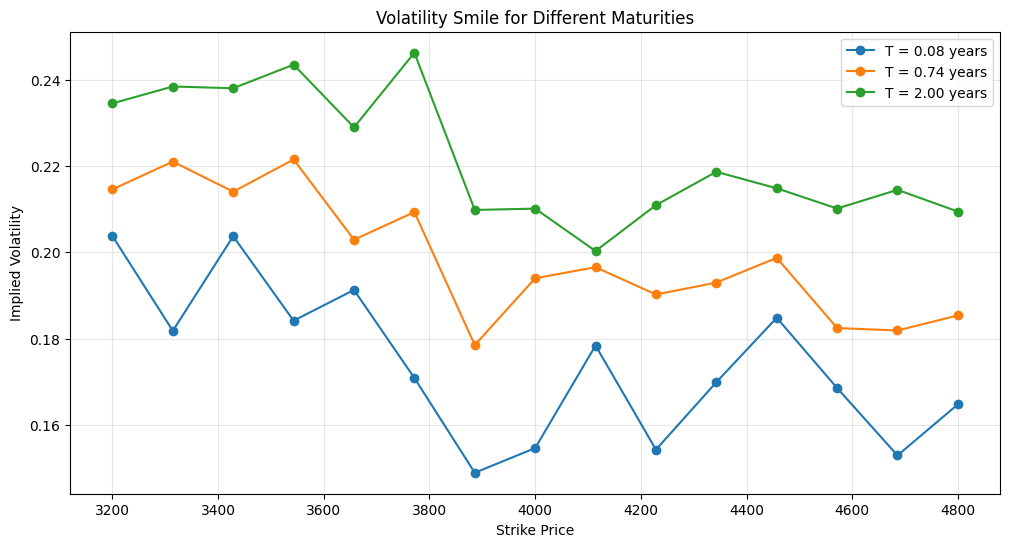

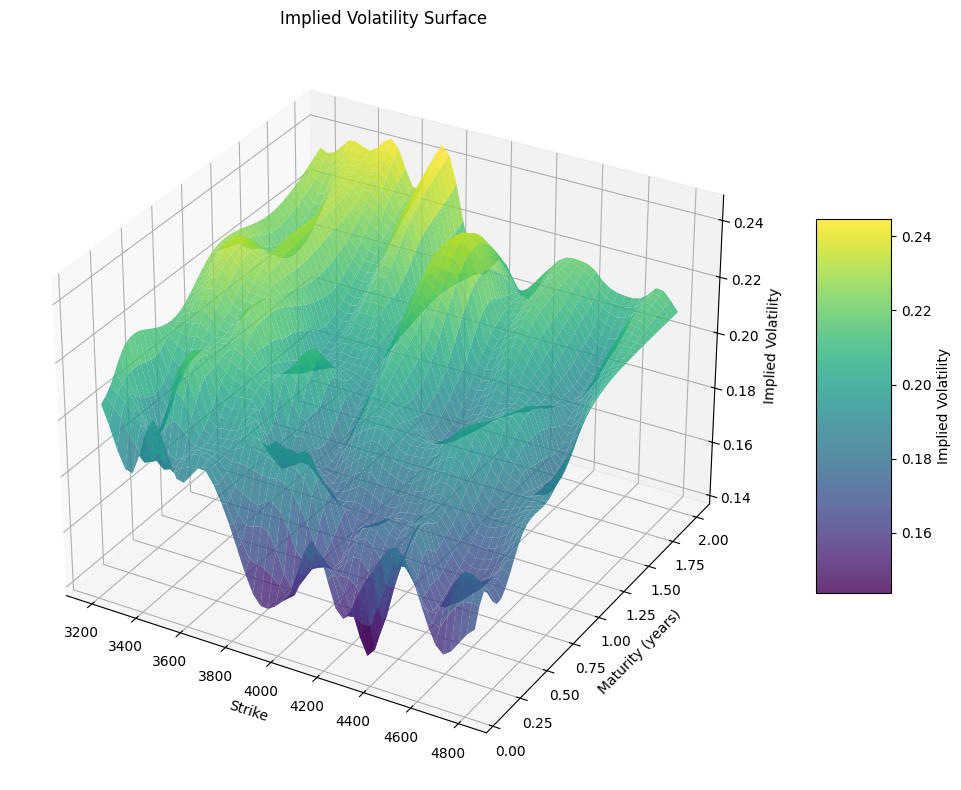

In [5]:
def analyze_volatility_surface(data=None, interpolation_method='cubic'):
    if data is None:
        data = generate_mock_options_data()
    plot_volatility_smile(data)
    if interpolation_method == 'rbf':
        rbf = interpolate_vol_surface_rbf(data)
        strike_range = np.linspace(data['strike'].min(), data['strike'].max(), 50)
        maturity_range = np.linspace(data['maturity'].min(), data['maturity'].max(), 50)
        X, Y = np.meshgrid(strike_range, maturity_range)
        Z = rbf(X, Y)
    else:
        X, Y, Z = interpolate_vol_surface(data, method=interpolation_method)
    plot_3d_vol_surface(X, Y, Z)
    plot_plotly_vol_surface(X, Y, Z)
    return data, X, Y, Z

# Run Analysis
data, X, Y, Z = analyze_volatility_surface(interpolation_method='cubic')


## Conclusion

This project demonstrates how to generate and visualize an implied volatility surface using mock option data.

From the smile plots and 3D surfaces, we observe:
- A typical **volatility smile**, especially for short maturities
- A **slight upward skew** in implied volatility as maturity increases
- A continuous surface that helps interpolate IVs across strikes and maturities